In [10]:
using Pkg
Pkg.activate(".")
using Plots, Dates, FourierTools
gr()

  Activating project at `~/CELESTE/PROJECTS/CA`


Plots.GRBackend()

In [11]:
gettime() = Dates.format(Dates.now(), "yyyy-mm-dd HH:MM:SS")

gettime (generic function with 1 method)

In [12]:
function generateAnimation(updatefunction::Function)
	begin
		anim = @animate for i = 1:100
			updatefunction(A)
			heatmap(A,
			colorbar=:none,
			aspect_ratio=:equal,
			showaxis=false,
			grid=false,
			ticks=false)
			# color=:greys)
		end
		# gif(anim, "cellgif.gif", fps = 30)
		gif(anim, "Results/$(gettime()).gif", fps = 30)

	end
end

generateAnimation (generic function with 1 method)

In [13]:
bwheatmap(X) = heatmap(X,
                        colorbar=:none,
                        aspect_ratio=:equal,
                        showaxis=false,
                        grid=false,
                        ticks=false,
                        color=:greys)
simpleheatmap(X) = heatmap(X,
                        colorbar=:none,
                        aspect_ratio=:equal,
                        showaxis=false,
                        grid=false,
                        ticks=false)

simpleheatmap (generic function with 1 method)

In [14]:
"""Periodic Index function"""
function pϵ(x, i, j)
    n,m=size(x)
    if (i > n)
        i = i % n
    elseif (i < 1)
        i = n + i % n
    end 

    if (j > m)
        j = j % m  
    elseif (j < 1)
        j = m + j % m
    end 
    x[i,j]
end

"""Index from the center (K[0, 0] returns the middle element).
 `K` must be square and have odd size."""
function cϵ(K, i, j)
    m, n = size(K)
    m′ = m ÷ 2 + 1
    n′ = n ÷ 2 + 1
    K[i+m′, j+n′]
end

cϵ

In [15]:
"""Convolution of K on A. Equivalent to:

`scipy.signal.convolve2d(A, K, mode="same", boundary="wrap")`"""
function convolve(A, K)
    C = zeros(Float64, size(A))
    m, n = size(A)
    mᴵ, nᴵ = size(K) .÷ 2 
    for i in 1:m, j in 1:n
        for iᴵ in -mᴵ:mᴵ, jᴵ in -nᴵ:nᴵ
            C[i, j] += pϵ(A, i+iᴵ, j+jᴵ) * cϵ(K, -iᴵ, -jᴵ) #strict
            # C[i, j] = pϵ(A, i+iᴵ, j+jᴵ) * cϵ(K, iᴵ, jᴵ) #basic
        end
    end
    C
end

convolve

In [16]:
function clip(u; a=0, b=1)
    if u>b 
        return b
    elseif u<a
        return a
    else 
        return u
    end
end

clip (generic function with 1 method)

Growth

In [ ]:
growth1(u) = (u==3) - ((u<2)|(u>3))

In [ ]:
function update3(A)
    K = [1 1 1
         1 0 1
         1 1 1]
    U = convolve(A, K)
    A .= clip.(A .+ growth1.(U))
end

In [ ]:
dimension = 100
A = rand(Bool, dimension, dimension);

In [ ]:
generateAnimation(update3)

Extended neighborhood: Bosco

In [ ]:
Bosco = [0 0 0 0 1 0 0 0 0 0 
		 0 0 1 1 1 1 1 0 0 0 
		 0 1 1 0 0 1 1 1 1 0 
		 1 1 0 0 0 1 1 1 1 1 
		 1 0 0 0 0 0 1 1 1 1 
		 1 1 0 0 0 0 1 1 1 1 
		 1 1 1 0 1 1 1 1 1 1 
		 0 1 1 1 1 1 1 1 1 0 
		 0 1 1 1 1 1 1 1 0 0 
		 0 0 1 1 1 1 1 0 0 0 
		 0 0 0 1 1 1 0 0 0 0]
bwheatmap(Bosco)

In [ ]:
function growth2(U) 
    b1, b2, s1, s2 = 34, 45, 34, 58
    return ((U>=b1)&(U<=b2)) - ((U<s1)|(U>s2))  
end

function update4(A)
    R = 5 #HALF KERNEL SIZE 
    K = ones(Int, 2R+1, 2R+1)

    U = convolve(A, K) 
    A .= clip.(A .+ growth2.(U))
end

In [ ]:
dimension = 100
A = zeros(Int, dimension,dimension);
cx, cy = 10, 10
m, n = size(Bosco)
A[cy:cy+m-1, cx:cx+n-1] .= Bosco
bwheatmap(A)

In [ ]:
generateAnimation(update4)

Multiple states

In [ ]:
dimension = 64
states = 12
A = rand(0:12, (dimension, dimension))

function growth5(U)
    return 0 + ((U>=20)&(U<=24)) - ((U<=18)|(U>=32))
end

function update5(A)
    K = [1 1 1 
         1 0 1 
         1 1 1]
    U = convolve(A, K)
    A .= (x -> clip(x, 0, states)).(A .+ growth5.(U))
end

In [ ]:
generateAnimation(update5)

Normalized kernel

In [ ]:
dimension = 64
A = rand(0:12, (dimension, dimension))

function growth6(U)
    return 0 + ((U>=0.20)&(U<=0.25)) - ((U<=0.18)|(U>=0.33))
end

function update6(A)
    states = 12
    K = [1 1 1 
         1 0 1 
         1 1 1]
    K = K ./ (states * sum(K))
    U = convolve(A, K)
    A .= (x -> clip(x, 0, states)).(A .+ growth6.(U))
end

generateAnimation(update6)

Continuous states and time

In [ ]:
dimension = 64
A = rand(dimension, dimension)

function growth7(U)
    return 0 + ((U>=0.20)&(U<=0.25)) - ((U<=0.18)|(U>=0.33))
end

function update7(A)
    T = 10
    K = [1 1 1 
         1 0 1 
         1 1 1]
    K = K ./ (sum(K))
    U = convolve(A, K)
    A .= clip.(A .+ (1/T) .* growth7.(U))
end

generateAnimation(update7)

Continuous space

In [ ]:
dimension = 64
A = rand(dimension, dimension)

T = 10
R = 5
K = ones(2R+1, 2R+1);
K[R+1, R+1] = 0.
K = K ./ (sum(K))

function growth8(U)
    return 0 + ((U>=0.12)&(U<=0.15)) - ((U<0.12)|(U>0.15))
end

function update8(A)
    U = convolve(A, K)
    A .= clip.(A .+ (1/T) .* growth8.(U))
end

generateAnimation(update8)

Remove orthogonal bias.

Use ring kernel

In [ ]:
dimension = 64
A = rand(dimension, dimension)

T = 10
R = 5
K=[0 0 0 0 1 1 1 0 0 0 0 
   0 0 1 1 1 1 1 1 1 0 0 
   0 1 1 1 1 1 1 1 1 1 0 
   0 1 1 1 1 1 1 1 1 1 0 
   1 1 1 1 0 0 0 1 1 1 1 
   1 1 1 1 0 0 0 1 1 1 1 
   1 1 1 1 0 0 0 1 1 1 1 
   0 1 1 1 1 1 1 1 1 1 0 
   0 1 1 1 1 1 1 1 1 1 0 
   0 0 1 1 1 1 1 1 1 0 0 
   0 0 0 0 1 1 1 0 0 0 0]
   
K = K ./ (sum(K))

function growth8(U)
    return 0 + ((U>=0.12)&(U<=0.15)) - ((U<0.12)|(U>0.15))
end

function update8(A)
    U = convolve(A, K)
    A .= clip.(A .+ (1/T) .* growth8.(U))
end

generateAnimation(update8)

Smooth kernel

In [ ]:
σ(x, m, s) = exp(-((x-m)/s)^2 / 2)
dimension = 64
A = rand(dimension, dimension)
T = 10
R = 10
K = zeros(2R+1, 2R+1)
m, n = size(K)

for i in 1:m, j in 1:n
    r = √((i-R-1)^2 + (j-R-1)^2)
    K[i, j] = σ(r, 0, 2)
end
K = K ./ (sum(K))
K[R+1, R+1]

generateAnimation(update8)

Circular Gaussian Kernel

In [ ]:
σ(x, m, s) = exp(-((x-m)/s)^2 / 2)
dimension = 64
A = rand(dimension, dimension)
T = 10
R = 10
K = zeros(2R+1, 2R+1)
m, n = size(K)

for i in 1:m, j in 1:n
    r = √((i-R-1)^2 + (j-R-1)^2) - 5
    K[i, j] = σ(r, 0, 2)
end
K = K ./ (sum(K))
K[R+1, R+1]

generateAnimation(update8)

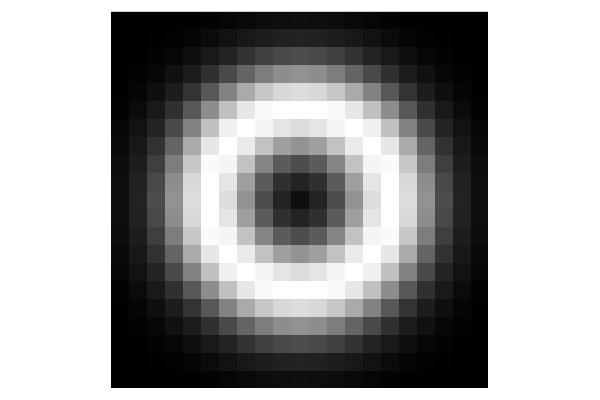

In [40]:
bwheatmap(K)

Corrected circular gaussian kernel

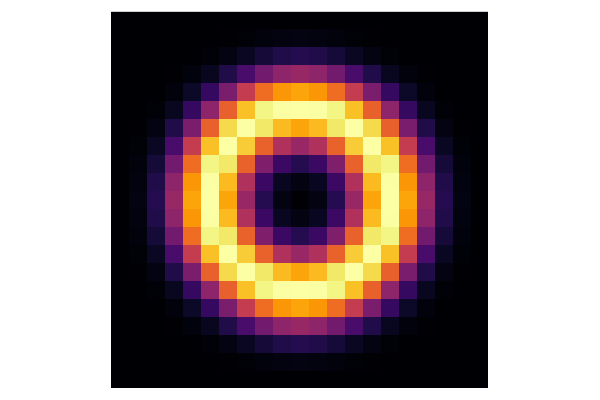

In [26]:
σ(x, m, s) = exp(-((x-m)/s)^2 / 2)
dimension = 64
A = rand(dimension, dimension)
T = 10
R = 10

D = [√(i^2+j^2) for i in -R:R, j in -R:R] ./ R
K = (D.<1) .* σ.(D, 0.5, 0.15)
simpleheatmap(K)

Smooth Growth

┌ Info: Saved animation to 
│   fn = /home/sharon/CELESTE/PROJECTS/CA/Results/2022-12-14 12:16:59.gif
└ @ Plots /home/sharon/.julia/packages/Plots/SkUg1/src/animation.jl:126


Plots.AnimatedGif("/home/sharon/CELESTE/PROJECTS/CA/Results/2022-12-14 12:16:59.gif")
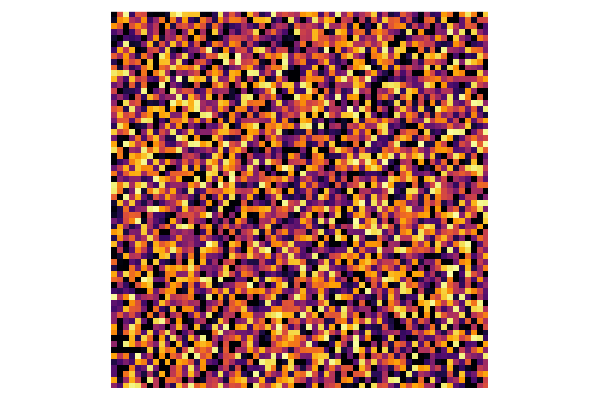

In [8]:
σ(x, m, s) = exp(-((x-m)/s)^2 / 2)
dimension = 64
A = rand(dimension, dimension)
T = 10
R = 10
K = zeros(2R+1, 2R+1)
m, n = size(K)

for i in 1:m, j in 1:n
    r = √((i-R-1)^2 + (j-R-1)^2) - 5
    K[i, j] = σ(r, 0, 2)
end
K = K ./ (sum(K))
K[R+1, R+1]

function growth9(U)
    m = 0.135
    s = 0.015
    σ(U, m, s)*2-1
end

function update9(A)
    U = convolve(A, K)
    A .= clip.(A .+ (1/T) .* growth9.(U))
end

generateAnimation(update9)

Orbium

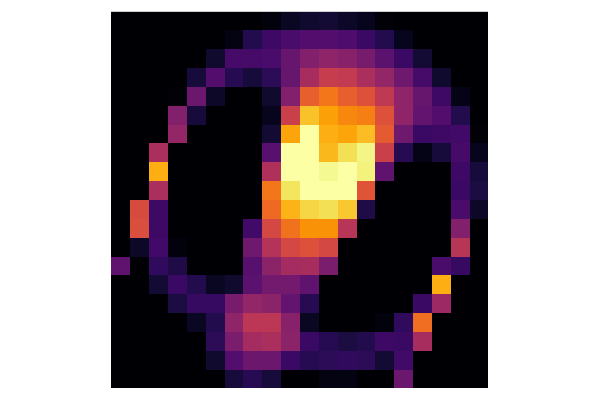

In [29]:
Orbium = [0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.14 0.1 0.0 0.0 0.03 0.03 0.0 0.0 0.3 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.08 0.24 0.3 0.3 0.18 0.14 0.15 0.16 0.15 0.09 0.2 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.15 0.34 0.44 0.46 0.38 0.18 0.14 0.11 0.13 0.19 0.18 0.45 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.06 0.13 0.39 0.5 0.5 0.37 0.06 0.0 0.0 0.0 0.02 0.16 0.68 0.0 0.0 0.0 
0.0 0.0 0.0 0.11 0.17 0.17 0.33 0.4 0.38 0.28 0.14 0.0 0.0 0.0 0.0 0.0 0.18 0.42 0.0 0.0 
0.0 0.0 0.09 0.18 0.13 0.06 0.08 0.26 0.32 0.32 0.27 0.0 0.0 0.0 0.0 0.0 0.0 0.82 0.0 0.0 
0.27 0.0 0.16 0.12 0.0 0.0 0.0 0.25 0.38 0.44 0.45 0.34 0.0 0.0 0.0 0.0 0.0 0.22 0.17 0.0 
0.0 0.07 0.2 0.02 0.0 0.0 0.0 0.31 0.48 0.57 0.6 0.57 0.0 0.0 0.0 0.0 0.0 0.0 0.49 0.0 
0.0 0.59 0.19 0.0 0.0 0.0 0.0 0.2 0.57 0.69 0.76 0.76 0.49 0.0 0.0 0.0 0.0 0.0 0.36 0.0 
0.0 0.58 0.19 0.0 0.0 0.0 0.0 0.0 0.67 0.83 0.9 0.92 0.87 0.12 0.0 0.0 0.0 0.0 0.22 0.07 
0.0 0.0 0.46 0.0 0.0 0.0 0.0 0.0 0.7 0.93 1.0 1.0 1.0 0.61 0.0 0.0 0.0 0.0 0.18 0.11 
0.0 0.0 0.82 0.0 0.0 0.0 0.0 0.0 0.47 1.0 1.0 0.98 1.0 0.96 0.27 0.0 0.0 0.0 0.19 0.1 
0.0 0.0 0.46 0.0 0.0 0.0 0.0 0.0 0.25 1.0 1.0 0.84 0.92 0.97 0.54 0.14 0.04 0.1 0.21 0.05 
0.0 0.0 0.0 0.4 0.0 0.0 0.0 0.0 0.09 0.8 1.0 0.82 0.8 0.85 0.63 0.31 0.18 0.19 0.2 0.01 
0.0 0.0 0.0 0.36 0.1 0.0 0.0 0.0 0.05 0.54 0.86 0.79 0.74 0.72 0.6 0.39 0.28 0.24 0.13 0.0 
0.0 0.0 0.0 0.01 0.3 0.07 0.0 0.0 0.08 0.36 0.64 0.7 0.64 0.6 0.51 0.39 0.29 0.19 0.04 0.0 
0.0 0.0 0.0 0.0 0.1 0.24 0.14 0.1 0.15 0.29 0.45 0.53 0.52 0.46 0.4 0.31 0.21 0.08 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.08 0.21 0.21 0.22 0.29 0.36 0.39 0.37 0.33 0.26 0.18 0.09 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.03 0.13 0.19 0.22 0.24 0.24 0.23 0.18 0.13 0.05 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.02 0.06 0.08 0.09 0.07 0.05 0.01 0.0 0.0 0.0 0.0 0.0]
simpleheatmap(Orbium)

In [ ]:
σ(x, m, s) = exp(-((x-m)/s)^2 / 2)
dimension = 64

cy, cx = 20, 20
A = zeros(dimension, dimension)
m, n = size(Orbium)
A[cy:cy+m-1, cx:cx+n-1] .= Orbium

T = 10
R = 13

D = [√(i^2+j^2) for i in -R:R, j in -R:R] ./ R
K = (D.<1) .* σ.(D, 0.5, 0.15)
K ./= sum(K)

function growth9(U)
    m = 0.15
    s = 0.015
    σ(U, m, s)*2-1
end

function update9(A)
    U = convolve(A, K)
    A .= clip.(A .+ (1/T) .* growth9.(U))
end

generateAnimation(update9)